# Product Review Classification

## Business Understanding
Our company wants a tool that will automatically classify product reviews as _positive_ or _negative_ reviews, based on the features of the review.  This will help our Product team to perform more sophisticated analyses in the future to help ensure customer satisfaction.

## Data Understanding
We have a labeled collection of 20,000 product reviews, with an equal split of positive and negative reviews. The dataset contains the following features:

 - `ProductId` Unique identifier for the product
 - `UserId` Unqiue identifier for the user
 - `ProfileName` Profile name of the user
 - `HelpfulnessNumerator` Number of users who found the review helpful
 - `HelpfulnessDenominator` Number of users who indicated whether they found the review helpful or not
 - `Time` Timestamp for the review
 - `Summary` Brief summary of the review
 - `Text` Text of the review
 - `PositiveReview` 1 if this was labeled as a positive review, 0 if it was labeled as a negative review

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("reviews.csv")
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,PositiveReview
0,B002QWHJOU,A37565LZHTG1VH,C. Maltese,1,1,1305331200,Awesome!,This is a great product. My 2 year old Golden ...,1
1,B000ESLJ6C,AMUAWXDJHE4D2,angieseashore,1,1,1320710400,Was there a recipe change?,I have been drinking Pero ever since I was a l...,0
2,B004IJJQK4,AMHHNAFJ9L958,A M,0,1,1321747200,These taste so bland.,"Look, each pack contains two servings of 120 c...",0


The data has already been cleaned, so there are no missing values

In [3]:
df.isna().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Time                      0
Summary                   0
Text                      0
PositiveReview            0
dtype: int64

`PositiveReview` is the target, and all other columns are features

In [4]:
X = df.drop("PositiveReview", axis=1)
y = df["PositiveReview"]

## Data Preparation

First, split into train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(15000, 8)

Second, prepare for modeling. The following `Pipeline` prepares all data for modeling.  It one-hot encodes the `ProductId`, applies a tf-idf vectorizer to the `Summary` and `Text`, keeps the numeric columns as-is, and drops all other columns.

The following code may take up to 1 minute to run.

In [18]:
def drop_irrelevant_columns(X):
    return X.drop(["UserId", "ProfileName"], axis=1)

pipeline = Pipeline(steps=[
    ("drop_columns", FunctionTransformer(drop_irrelevant_columns, validate=False)),
    ("transform_text_columns", ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False), ["ProductId"]),
        ("summary-tf-idf", TfidfVectorizer(max_features=1000), "Summary"),
        ("text-tf-idf", TfidfVectorizer(max_features=1000), "Text")
    ], remainder="passthrough"))
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

X_train_transformed.shape

(15000, 11275)

## Modeling

Fit a `RandomForestClassifier` with the best hyperparameters.  The following code may take up to 1 minute to run.

In [19]:
rfc = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=30,
    min_samples_split=15,
    min_samples_leaf=1
)
rfc.fit(X_train_transformed, y_train)

RandomForestClassifier(max_depth=30, min_samples_split=15, random_state=42)

## Model Evaluation

We are using _accuracy_ as our metric, which is the default metric in Scikit-Learn, so it is possible to just use the built-in `.score` method

In [20]:
print("Train accuracy:", rfc.score(X_train_transformed, y_train))
print("Test accuracy:", rfc.score(X_test_transformed, y_test))

Train accuracy: 0.9846666666666667
Test accuracy: 0.9116


In [21]:
print("Train confusion matrix:")
print(confusion_matrix(y_train, rfc.predict(X_train_transformed)))
print("Test confusion matrix:")
print(confusion_matrix(y_test, rfc.predict(X_test_transformed)))

Train confusion matrix:
[[7323  166]
 [  64 7447]]
Test confusion matrix:
[[2286  225]
 [ 217 2272]]


## Business Interpretation

The tuned Random Forest Classifier model appears to be somewhat overfit on the training data, but nevertheless achieves 91% accuracy on the test data.  Of the 9% of mislabeled comments, about half are false positives and half are false negatives.

Because this is a balanced dataset, 91% accuracy is a substantial improvement over a 50% baseline.  This model is ready for production use for decision support.

# TensorFlow Model

## Data Preparation

In [10]:
from sklearn.preprocessing import StandardScaler

In [32]:
#X_train_transformed = pipeline.fit_transform(X_train)
#X_test_transformed = pipeline.transform(X_test)

ss= StandardScaler()

X_tr_t_ss = ss.fit_transform(X_train_transformed)

#scale test data
X_te_t_ss = ss.transform(X_test_transformed)

## Modeling

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score

In [59]:
model = Sequential()

In [60]:
#input Dense layer
model.add(Dense(units=64, activation = 'relu', input_shape = (11275,)))

#hidden layers
model.add(Dense(units=64, activation = 'tanh'))
model.add(Dense(units=64, activation = 'relu'))

#output Dense layer
model.add(Dense(1, activation = 'sigmoid'))

#compile model

model.compile(loss= 'binary_crossentropy', metrics = ['accuracy'])


In [61]:
#fit the model on the preprocessed training data
tf_model = model.fit(X_tr_t_ss,
                    y_train,
                    epochs=5,
                    batch_size=20, validation_split=.1)


Epoch 1/5
675/675 [==============================] - 3s 4ms/step - loss: 0.2661 - accuracy: 0.8877 - val_loss: 0.1744 - val_accuracy: 0.9387
Epoch 2/5
675/675 [==============================] - 3s 4ms/step - loss: 0.0814 - accuracy: 0.9718 - val_loss: 0.2005 - val_accuracy: 0.9320
Epoch 3/5
675/675 [==============================] - 3s 4ms/step - loss: 0.0375 - accuracy: 0.9884 - val_loss: 0.2782 - val_accuracy: 0.9253
Epoch 4/5
675/675 [==============================] - 3s 4ms/step - loss: 0.0197 - accuracy: 0.9946 - val_loss: 0.3597 - val_accuracy: 0.9227
Epoch 5/5
675/675 [==============================] - 3s 4ms/step - loss: 0.0086 - accuracy: 0.9985 - val_loss: 0.5575 - val_accuracy: 0.9267


## Model Tuning + Feature Engineering

In [35]:
model2 = Sequential()

In [36]:
#input Dense layer
model2.add(Dense(units=50, activation = 'relu', input_shape = (11275,)))

#hidden layers
model2.add(Dense(units=64, activation = 'tanh'))
model2.add(Dense(units=70, activation = 'elu'))

#output Dense layer
model2.add(Dense(1, activation = 'sigmoid'))

#compile model

model2.compile(loss= 'binary_crossentropy', metrics = ['accuracy'], optimizer='SGD')

In [37]:
tf_model2 = model2.fit(X_tr_t_ss,
                    y_train,
                    epochs=10,
                    batch_size=25, validation_split=.1)


Epoch 1/10
600/600 [==============================] - 2s 3ms/step - loss: 0.2573 - accuracy: 0.8897
Epoch 2/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0863 - accuracy: 0.9701
Epoch 3/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0412 - accuracy: 0.9867
Epoch 4/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0220 - accuracy: 0.9935
Epoch 5/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0124 - accuracy: 0.9963
Epoch 6/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0072 - accuracy: 0.9983
Epoch 7/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0050 - accuracy: 0.9987
Epoch 8/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0039 - accuracy: 0.9993
Epoch 9/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0021 - accuracy: 0.9997
Epoch 10/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0018 - accuracy: 0.9997

In [54]:
y_hat_test2 = model2.predict_classes(X_te_t_ss)
accuracy_score(y_test, y_hat_test2)

0.8968

In [46]:
model3 = Sequential()

In [51]:
#input Dense layer
model3.add(Dense(units=50, activation = 'relu', input_shape = (11275,)))

#hidden layers
model3.add(Dense(units=64, activation = 'tanh'))
model3.add(Dense(units=70, activation = 'elu'))
model3.add(Dense(units=64, activation = 'relu'))

#output Dense layer
model3.add(Dense(1, activation = 'sigmoid'))

#compile model

model3.compile(loss= 'binary_crossentropy', metrics = ['accuracy'], optimizer='SGD')

In [52]:
tf_model3 = model3.fit(X_tr_t_ss,
                    y_train,
                    epochs=10,
                    batch_size=25, validation_split=.1)

Epoch 1/10
540/540 [==============================] - 1s 2ms/step - loss: 0.2524 - accuracy: 0.9943 - val_loss: 0.3189 - val_accuracy: 0.8900
Epoch 2/10
540/540 [==============================] - 1s 2ms/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.3967 - val_accuracy: 0.8913
Epoch 3/10
540/540 [==============================] - 1s 2ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.4446 - val_accuracy: 0.8913
Epoch 4/10
540/540 [==============================] - 1s 2ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.4772 - val_accuracy: 0.8920
Epoch 5/10
540/540 [==============================] - 1s 2ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.5018 - val_accuracy: 0.8920
Epoch 6/10
540/540 [==============================] - 1s 2ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.5214 - val_accuracy: 0.8920
Epoch 7/10
540/540 [==============================] - 1s 2ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5376 - val_accuracy: 0.8920
Epoch 

In [53]:
y_hat_test3 = model3.predict_classes(X_te_t_ss)
accuracy_score(y_test, y_hat_test3)

0.901

## Model Evaluation

In [67]:
f_model= Sequential()

In [68]:
#input Dense layer
f_model.add(Dense(units=64, activation = 'relu', input_shape = (11275,)))

#hidden layers
f_model.add(Dense(units=64, activation = 'tanh'))
f_model.add(Dense(units=64, activation = 'relu'))
f_model.add(Dense(units=64, activation = 'sigmoid'))

#output Dense layer
f_model.add(Dense(1, activation = 'sigmoid'))

#compile model

f_model.compile(loss= 'binary_crossentropy', metrics = ['accuracy'])


In [69]:
f_tf_model = f_model.fit(X_tr_t_ss,
                    y_train,
                    epochs=5,
                    batch_size=20)

Epoch 1/5
750/750 [==============================] - 3s 4ms/step - loss: 0.2594 - accuracy: 0.8931
Epoch 2/5
750/750 [==============================] - 3s 4ms/step - loss: 0.0879 - accuracy: 0.9702
Epoch 3/5
750/750 [==============================] - 3s 4ms/step - loss: 0.0426 - accuracy: 0.9869
Epoch 4/5
750/750 [==============================] - 3s 4ms/step - loss: 0.0211 - accuracy: 0.9944
Epoch 5/5
750/750 [==============================] - 3s 4ms/step - loss: 0.0122 - accuracy: 0.9975


In [73]:
y_hat_test_f = f_model.predict_classes(X_te_t_ss)
accuracy_score(y_test, y_hat_test_f)

0.9192

In [76]:
y_hat_train_f = f_model.predict_classes(X_tr_t_ss)
accuracy_score(y_train, y_hat_train_f)

0.9986666666666667

## Technical Communication

In [75]:
print("RFC Train accuracy:", rfc.score(X_train_transformed, y_train))
print("RFC Test accuracy:", rfc.score(X_test_transformed, y_test))

RFC Train accuracy: 0.9846666666666667
RFC Test accuracy: 0.9116


In [95]:
print("TF Train accuracy:", accuracy_score(y_train, y_hat_train_f))
print("TF Test accuracy:", accuracy_score(y_test, y_hat_test_f))


TF Train accuracy: 0.9986666666666667
TF Test accuracy: 0.9192


#### The trainng and testing accuracy for both models is simlar. Given this, it is recommended to use Random Forest Classifier(RFC) because it is less computationaly expensive than Tensor Flow Neural Network(TF). This should be taken into consideration as more data is gathered in the future and the run times will increase. There is not a significant improvement in using TF. RFC will also provide a more detailed explanation of what is happening at every step.  TF is a bit more ambiguous and more difficult to pinpoint what is occuring at each step. 

In [91]:
f_model

In [90]:
rfc

RandomForestClassifier(max_depth=30, min_samples_split=15, random_state=42)

### visualization 

In [81]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
#spent time playing around with model and didn't see the visualization piece.  Then had trouble converting Sequential into classifier. 
#ran out of time to troubleshoot

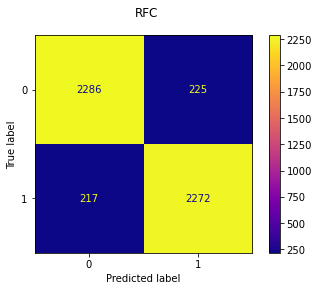

In [96]:
fig, ax = plt.subplots()

fig.suptitle("RFC")

plot_confusion_matrix(rfc, X_test_transformed, y_test, ax=ax, cmap="plasma");

In [93]:
f_model_cm = f_model.math.confusion_matrix(
    y_train, y_hat_train_f,  dtype=tf.dtypes.int32,
   
)

AttributeError: 'Sequential' object has no attribute 'math'

ValueError: plot_confusion_matrix only supports classifiers

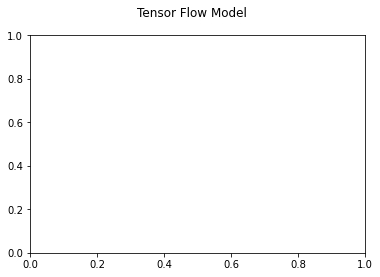

In [99]:
fig, ax = plt.subplots()

fig.suptitle("Tensor Flow Model")

plot_confusion_matrix(f_model, X_te_t_ss, y_test, ax=ax, cmap="plasma");

In [98]:
f_model.save("tf_final_model")


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: tf_final_model/assets
